In [ ]:
!pip install neo4j

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.7/301.7 kB 4.9 MB/s eta 0:00:00


In [ ]:
import neo4j
from neo4j import GraphDatabase
import pandas
from matplotlib import pyplot as plt

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
URI = "neo4j+s://e4b06f6d.databases.neo4j.io"
AUTH = ("neo4j", "SQjPaQXG9mpqi6ulxIXeTHF-QyJy1RK-ePRUFuLnfSM")

with GraphDatabase.driver(URI, auth=AUTH) as driver:
    driver.verify_connectivity()

df = driver.execute_query(
  """
  MATCH (d:Driver)-[:DELIVER]->(res:Result)-[:TAKE_PLACE]->(r:Race)<-[:PLAN]-(s:Season)
  WITH d, collect({race: r, result: res}) AS finishes
  WHERE ANY(finish IN finishes WHERE finish.result.positionOrder IN [1, 2, 3])
  UNWIND finishes AS finish
  WITH d, finish.race AS race, finish.result.positionOrder AS positionOrder, finish.race.date AS raceDate
  ORDER BY raceDate ASC
  WITH d, collect({race: race, positionOrder: positionOrder}) AS orderedRaces
  WITH d, orderedRaces,
    REDUCE(
      s = { val: 0, podium: 1 },
      r IN orderedRaces |
      CASE
          WHEN r.positionOrder IN [1, 2, 3] AND s.podium = 1 THEN
            { val: s.val, podium: 0 }
          ELSE
            { val: s.val + s.podium * 1, podium: s.podium }
      END
    ) AS racesBeforePodium
  RETURN d.forename AS forename, d.surname AS surname, racesBeforePodium.val AS racesBeforePodium
  ORDER BY racesBeforePodium DESC
  """,
  database_="neo4j",
  result_transformer_=neo4j.Result.to_df
)

In [ ]:
df.head()

,forename,surname,racesBeforePodium
0,Carlos,Sainz,100
1,Martin,Brundle,97
2,Mika,Salo,72
3,Nicola,Larini,69
4,Johnny,Herbert,69


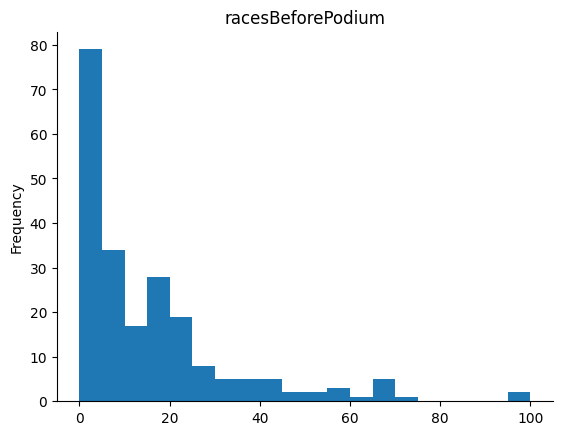

In [ ]:
df['racesBeforePodium'].plot(kind='hist', bins=20, title='racesBeforePodium')
plt.gca().spines[['top', 'right',]].set_visible(False)